In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import time
sns.set_theme()
import random
random.seed(42)
np.random.seed(42)

In [2]:
df = pd.read_csv('2019EE10577.csv',header=None)

In [3]:
NUM_FEATURES = 784

In [4]:
def getData():
    X,y = [],[]
    for i,row in df.iterrows():
        X.append(row[:NUM_FEATURES])
        y.append(int(row[NUM_FEATURES]))
    return X,y

In [5]:
Xorig,Yorig = getData()

In [6]:
def plot_acc(train_acc_list,test_acc_list,name):
    xa = np.linspace(1,len(train_acc_list),len(train_acc_list),dtype=int)
    plt.figure()
    train_acc_list = np.array(train_acc_list) * 100
    test_acc_list = np.array(test_acc_list) * 100
    plt.plot(xa,train_acc_list,color="g",label = "Training accuracy")
    plt.plot(xa,test_acc_list,color="r", label = "Testing accuracy")
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Iterations')
    plt.legend()
    plt.savefig(f'Accuracy_{name}.png',dpi=1200)
    plt.show()

In [7]:
def plot_error(train_err_list,test_err_list,name):
    xa = np.linspace(1,len(train_err_list),len(train_err_list),dtype=int)
    plt.figure()
    plt.plot(xa,train_err_list,color="g",label="Training error")
    plt.plot(xa,test_err_list,color="r",label="Testing error")
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Error vs Iterations')
    plt.legend()
    plt.savefig(f'Error_{name}.png',dpi=1200)
    plt.show()

In [8]:
def relu(x): # 1
    return np.maximum(0,x)

def relu_der(x):
    x[x>0] = 1
    x[x<=0] = 0
    return np.array(x)

def sigmoid(x): # 2
    return 1/(1+np.exp(-1.*x))

def sigmoid_der(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x): # 3
    return np.tanh(x)

def tanh_der(x):
    return 1-np.square(np.tanh(x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [9]:
def chunkarr(arr, n):
    return [arr[i:i + n] for i in range(0, len(arr), n)]

In [10]:
def getAccuracy(y,t):
    y = np.argmax(y,axis=1)
    t = np.argmax(t,axis=1)
    return np.sum((y==t))/len(y)

In [95]:
class NN:
    def __init__(self,early = True,epochs=100,layers=2,nodes=[50,75],alpha=0.0003,bs=16,eps=0.0005,activation=1,reg=1,lam =0):
        np.random.seed(42)
        self.epochs = epochs
        self.layers = layers
        self.nodes = nodes
        self.alpha = alpha
        self.bs = bs
        self.eps = eps
        self.activation = activation
        self.reg = reg
        self.lam = lam
        self.w = [np.random.randn(NUM_FEATURES,self.nodes[0])]
        self.b = [np.random.randn(self.nodes[0])]
        self.z = [0] * (self.layers +1)
        self.a = [0] * (self.layers)
        self.dw = [0]*(self.layers+1)
        self.db = [0]*(self.layers+1)
        self.early = early
        
        for i in range(1,self.layers):
            self.w.append(np.random.randn(self.nodes[i-1],self.nodes[i]))
            self.b.append(np.random.randn(self.nodes[i]))
        
        self.w.append(0.1*np.random.randn(self.nodes[self.layers-1],10))
        self.b.append(np.random.randn(10))
        
    
    def activation_fn(self,x):
        if self.activation == 1:
            return relu(x)
        elif self.activation == 2:
            return sigmoid(x)
        elif self.activation == 3:
            return tanh(x)
    
    def der_activation_fn(self,x):
        if self.activation == 1:
            return relu_der(x)
        elif self.activation == 2:
            return sigmoid_der(x)
        elif self.activation == 3:
            return tanh_der(x)
    
    def f_prop(self,X):
        self.z[0] = np.dot(X,self.w[0]) + self.b[0]
        self.a[0] = self.activation_fn(self.z[0])
        for i in range(1,self.layers):
            self.z[i] = np.dot(self.a[i-1],self.w[i]) + self.b[i]
            self.a[i] = self.activation_fn(self.z[i])
        self.z[self.layers] = np.dot(self.a[self.layers-1],self.w[self.layers]) + self.b[self.layers]
    
    def back_prop(self,X,t,y):
        temp = y-t
        self.dw[self.layers] = (np.dot(self.a[self.layers-1].T,temp)+ 
                                self.lam*self.w[self.layers])/self.bs                                
        self.db[self.layers] = (np.sum(temp,axis=0))/self.bs
        
        for i in range(self.layers-1,-1,-1):
            aux = np.dot(temp,self.w[i+1].T)
            der = self.der_activation_fn(self.a[i])
            temp = aux*der
            if i>0:
                self.dw[i] = (np.dot(self.a[i-1].T,temp) + self.lam*self.w[i])/self.bs
            else:
                self.dw[0] = (np.dot(X.T,temp) + self.lam*self.w[0])/self.bs
            self.db[i] = np.sum(temp,axis=0)/self.bs
        
    def train(self,X,t,log=False):
        t_onehot = np.zeros((len(t),10))
        t_onehot[np.arange(len(t_onehot)),t] = 1
        t = t_onehot
        trainX = np.array(X[:2700])
        traint = np.array(t[:2700])
        testX = np.array(X[2700:])
        testt = np.array(t[2700:])
        
        Xchunks = chunkarr(trainX, self.bs)
        tchunks = chunkarr(traint, self.bs)
        
        # calculate accuracy here
        train_acc_list = []
        train_error_list = []
        test_acc_list = []
        test_error_list = []
        train_pred = self.predict(trainX)
        test_pred = self.predict(testX)
        
        trainacc = getAccuracy(train_pred,traint)
        testacc = getAccuracy(test_pred,testt)
        trainerror = -1*np.sum(traint*np.log(train_pred))/len(trainX)
        testerror = -1*np.sum(testt*np.log(test_pred))/len(testX)
        
        train_acc_list.append(trainacc)
        test_acc_list.append(testacc)
        train_error_list.append(trainerror)
        test_error_list.append(testerror)
        
        
        
        for epoch in (range(self.epochs)):
            t1 = time.time()
            for chunk in range(len(Xchunks)):
                Xcon = Xchunks[chunk]
                tcon = tchunks[chunk]
                
                self.f_prop(Xcon)
                y = softmax(self.z[self.layers])
                
                # call backprop here
                self.back_prop(Xcon,tcon,y)
                
                for i in range(self.layers+1):
                    self.w[i] -= self.alpha * self.dw[i]
                    self.b[i] -= self.alpha * self.db[i]
            
            t2 = time.time()
            
            # calculate accuracies here
            train_pred = self.predict(trainX)
            test_pred = self.predict(testX)

            trainacc = getAccuracy(train_pred,traint)
            testacc = getAccuracy(test_pred,testt)
            trainerror = -1*np.sum(traint*np.log(train_pred))/len(trainX)
            testerror = -1*np.sum(testt*np.log(test_pred))/len(testX)

            train_acc_list.append(trainacc)
            test_acc_list.append(testacc)
            train_error_list.append(trainerror)
            test_error_list.append(testerror)
            
            if self.early:
                if trainacc >0.7:
                    if abs(train_acc_list[-1] - train_acc_list[-2]) < self.eps:
                        if abs(train_acc_list[-2] - train_acc_list[-3]) < self.eps:
                            if abs(train_acc_list[-3] - train_acc_list[-4]) < self.eps:
                                break
            
            if log:
                print(f"epoch: {epoch+1}/{self.epochs}")
                print(f"time: {round(t2-t1,4)}, training_acc: {round(trainacc,4)}, test_acc: {round(testacc,4)}")
            
        return train_acc_list,test_acc_list,train_error_list,test_error_list
                
    def predict(self,X):
        self.z = [0] * (self.layers +1)
        self.a = [0] * (self.layers)
        self.f_prop(X)
        return softmax(self.z[self.layers])
        
    

In [67]:
nn = NN(epochs = 100,alpha=0.004,layers=2,nodes=[100,64],lam=1e-5)

In [68]:
train_acc_list,test_acc_list,train_error_list,test_error_list = nn.train(Xorig,Yorig,log=True)

epoch: 1/100
time: 0.18, training_acc: 0.6537, test_acc: 0.5733
epoch: 2/100
time: 0.15, training_acc: 0.7041, test_acc: 0.6433
epoch: 3/100
time: 0.1601, training_acc: 0.7159, test_acc: 0.6433
epoch: 4/100
time: 0.16, training_acc: 0.7448, test_acc: 0.6733
epoch: 5/100
time: 0.17, training_acc: 0.7252, test_acc: 0.66
epoch: 6/100
time: 0.16, training_acc: 0.7411, test_acc: 0.6933
epoch: 7/100
time: 0.16, training_acc: 0.7219, test_acc: 0.6767
epoch: 8/100
time: 0.16, training_acc: 0.7344, test_acc: 0.6867
epoch: 9/100
time: 0.15, training_acc: 0.7419, test_acc: 0.6967
epoch: 10/100
time: 0.15, training_acc: 0.7333, test_acc: 0.6733
epoch: 11/100
time: 0.17, training_acc: 0.7541, test_acc: 0.69
epoch: 12/100
time: 0.17, training_acc: 0.7511, test_acc: 0.69
epoch: 13/100
time: 0.17, training_acc: 0.7656, test_acc: 0.7067
epoch: 14/100
time: 0.17, training_acc: 0.7533, test_acc: 0.69
epoch: 15/100
time: 0.16, training_acc: 0.7715, test_acc: 0.7033
epoch: 16/100
time: 0.16, training_acc: 

In [69]:
train_list = []
test_list = []
time_list = []
for reg in tqdm([1e-14,1e-10,1e-6,1e-2,1e2,1e6]):
    t1 = time.time()
    nn = NN(epochs = 100,alpha=0.004,layers=2,nodes=[100,64],lam=reg)
    train_acc_list,test_acc_list,train_error_list,test_error_list = nn.train(Xorig,Yorig,log=False)
    t2 = time.time()
    time_list.append(t2-t1)
    train_list.append(train_acc_list[-1])
    test_list.append(test_acc_list[-1])

c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
c:\users\kshitij alwadhi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


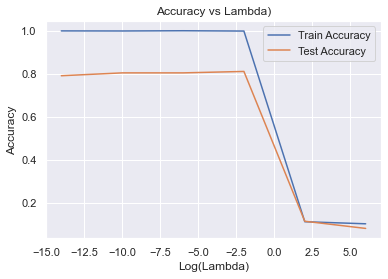

In [70]:
X = [-14,-10,-6,-2,2,6]
plt.plot(X,train_list, label="Train Accuracy")
plt.plot(X,test_list,label="Test Accuracy")
plt.xlabel('Log(Lambda)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Lambda)')
plt.legend()
plt.savefig('Plots/Accuracy vs Lambda_1.png',dpi=1200)
plt.show()

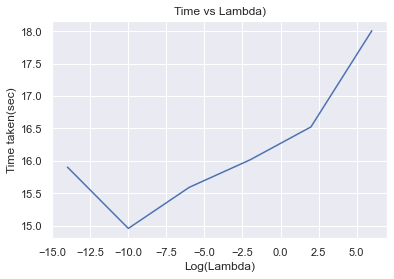

In [71]:
X = [-14,-10,-6,-2,2,6]
plt.plot(X,time_list, label="Time taken")
plt.xlabel('Log(Lambda)')
plt.ylabel('Time taken(sec)')
plt.title('Time vs Lambda)')
plt.savefig('Plots/Time vs Lambda_1.png',dpi=1200)
plt.show()

In [72]:
tempdf = pd.DataFrame({'lam':[-14,-10,-6,-2,2,6],'train_acc':train_list,'test_acc':test_list,'time_taken':time_list})
tempdf

,lam,train_acc,test_acc,time_taken
0,-14,0.998519,0.790000,15.902141
1,-10,0.998148,0.803333,14.956310
2,-6,0.999259,0.803333,15.590128
3,-2,0.997778,0.810000,16.014454
4,2,0.111111,0.113333,16.522977
5,6,0.101481,0.080000,18.006861


In [73]:
train_list = []
test_list = []
time_list = []
for reg in tqdm([0.01,0.05,0.1,0.5,1,5]):
    t1 = time.time()
    nn = NN(epochs = 100,alpha=0.004,layers=2,nodes=[100,64],lam=reg)
    train_acc_list,test_acc_list,train_error_list,test_error_list = nn.train(Xorig,Yorig,log=False)
    t2 = time.time()
    time_list.append(t2-t1)
    train_list.append(train_acc_list[-1])
    test_list.append(test_acc_list[-1])

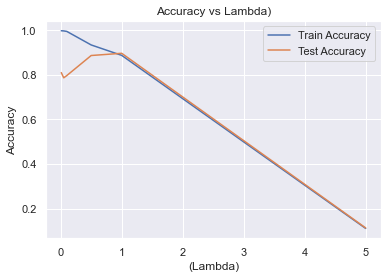

In [74]:
X = [0.01,0.05,0.1,0.5,1,5]
plt.plot(X,train_list, label="Train Accuracy")
plt.plot(X,test_list,label="Test Accuracy")
plt.xlabel('(Lambda)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Lambda)')
plt.legend()
plt.savefig('Plots/Accuracy vs Lambda_2.png',dpi=1200)
plt.show()

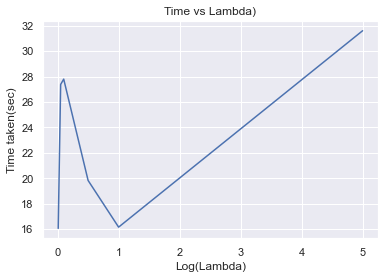

In [75]:
X = [0.01,0.05,0.1,0.5,1,5]
plt.plot(X,time_list, label="Time taken")
plt.xlabel('Log(Lambda)')
plt.ylabel('Time taken(sec)')
plt.title('Time vs Lambda)')
plt.savefig('Plots/Time vs Lambda_2.png',dpi=1200)
plt.show()

In [76]:
tempdf = pd.DataFrame({'lam':[0.01,0.05,0.1,0.5,1,5],'train_acc':train_list,'test_acc':test_list,'time_taken':time_list})
tempdf

,lam,train_acc,test_acc,time_taken
0,0.01,0.997778,0.810000,16.045384
1,0.05,0.997037,0.786667,27.378482
2,0.10,0.994815,0.796667,27.799001
3,0.50,0.934074,0.886667,19.820700
4,1.00,0.887407,0.896667,16.145968
5,5.00,0.111111,0.113333,31.607286


In [77]:
train_list = []
test_list = []
time_list = []
for alpha in tqdm([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2]):
    t1 = time.time()
    nn = NN(epochs = 100,alpha=alpha,layers=2,nodes=[100,64],lam=0.5)
    train_acc_list,test_acc_list,train_error_list,test_error_list = nn.train(Xorig,Yorig,log=False)
    t2 = time.time()
    time_list.append(t2-t1)
    train_list.append(train_acc_list[-1])
    test_list.append(test_acc_list[-1])

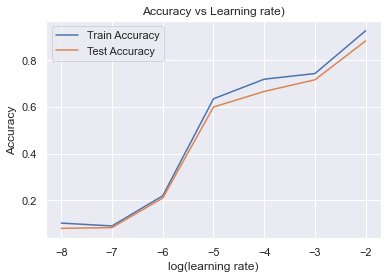

In [78]:
X = [-8,-7,-6,-5,-4,-3,-2]
plt.plot(X,train_list, label="Train Accuracy")
plt.plot(X,test_list,label="Test Accuracy")
plt.xlabel('log(learning rate)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning rate)')
plt.legend()
plt.savefig('Plots/Accuracy vs LR_1.png',dpi=1200)
plt.show()

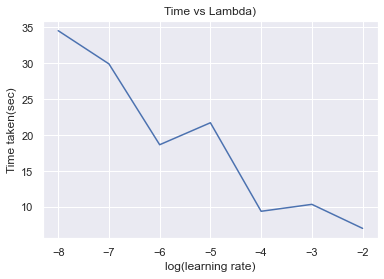

In [79]:
X = [-8,-7,-6,-5,-4,-3,-2]
plt.plot(X,time_list, label="Time taken")
plt.xlabel('log(learning rate)')
plt.ylabel('Time taken(sec)')
plt.title('Time vs Lambda)')
plt.savefig('Plots/Time vs LR_1.png',dpi=1200)
plt.show()

In [80]:
tempdf = pd.DataFrame({'LR':[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2],'train_acc':train_list,'test_acc':test_list,'time_taken':time_list})
tempdf

,LR,train_acc,test_acc,time_taken
0,1.000000e-08,0.102593,0.080000,34.551819
1,1.000000e-07,0.090370,0.083333,29.931592
2,1.000000e-06,0.219630,0.210000,18.679262
3,1.000000e-05,0.635185,0.600000,21.738911
4,1.000000e-04,0.719259,0.666667,9.415470
5,1.000000e-03,0.743333,0.716667,10.381021
6,1.000000e-02,0.927037,0.883333,7.037894


In [81]:
train_list = []
test_list = []
time_list = []
for alpha in tqdm([1e-3,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3]):
    t1 = time.time()
    nn = NN(epochs = 100,alpha=alpha,layers=2,nodes=[100,64],lam=0.5)
    train_acc_list,test_acc_list,train_error_list,test_error_list = nn.train(Xorig,Yorig,log=False)
    t2 = time.time()
    time_list.append(t2-t1)
    train_list.append(train_acc_list[-1])
    test_list.append(test_acc_list[-1])

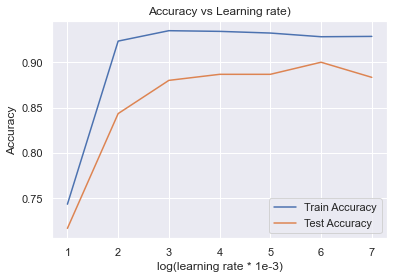

In [82]:
X = [1,2,3,4,5,6,7]
plt.plot(X,train_list, label="Train Accuracy")
plt.plot(X,test_list,label="Test Accuracy")
plt.xlabel('log(learning rate * 1e-3)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning rate)')
plt.legend()
plt.savefig('Plots/Accuracy vs LR_2.png',dpi=1200)
plt.show()

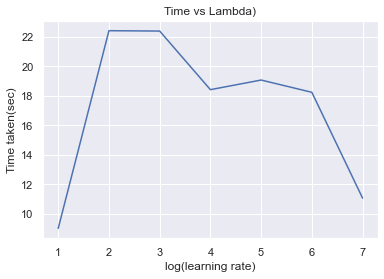

In [83]:
plt.plot(X,time_list, label="Time taken")
plt.xlabel('log(learning rate)')
plt.ylabel('Time taken(sec)')
plt.title('Time vs Lambda)')
plt.savefig('Plots/Time vs LR_2.png',dpi=1200)
plt.show()

In [84]:
tempdf = pd.DataFrame({'LR':[1e-3,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3],'train_acc':train_list,'test_acc':test_list,'time_taken':time_list})
tempdf

,LR,train_acc,test_acc,time_taken
0,0.001,0.743333,0.716667,9.007805
1,0.002,0.923333,0.843333,22.419587
2,0.003,0.934815,0.880000,22.394939
3,0.004,0.934074,0.886667,18.418861
4,0.005,0.932222,0.886667,19.071711
5,0.006,0.928148,0.900000,18.239354
6,0.007,0.928519,0.883333,11.061211


In [86]:
train_list = []
test_list = []
time_list = []
for bs in tqdm([8,16,32,64]):
    t1 = time.time()
    nn = NN(epochs = 100,alpha=5e-3,layers=2,nodes=[100,64],lam=0.5,bs=bs)
    train_acc_list,test_acc_list,train_error_list,test_error_list = nn.train(Xorig,Yorig,log=False)
    t2 = time.time()
    time_list.append(t2-t1)
    train_list.append(train_acc_list[-1])
    test_list.append(test_acc_list[-1])

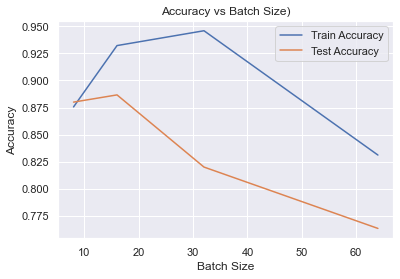

In [87]:
X = [8,16,32,64]
plt.plot(X,train_list, label="Train Accuracy")
plt.plot(X,test_list,label="Test Accuracy")
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size)')
plt.legend()
plt.savefig('Plots/Accuracy vs BS_1.png',dpi=1200)
plt.show()

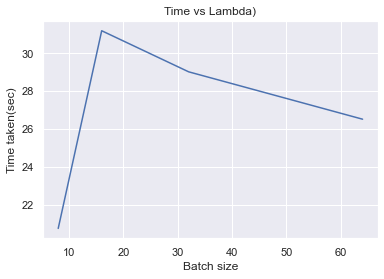

In [88]:
plt.plot(X,time_list, label="Time taken")
plt.xlabel('Batch size')
plt.ylabel('Time taken(sec)')
plt.title('Time vs Lambda)')
plt.savefig('Plots/Time vs BS_1.png',dpi=1200)
plt.show()

In [89]:
tempdf = pd.DataFrame({'BS':[8,16,32,64],'train_acc':train_list,'test_acc':test_list,'time_taken':time_list})
tempdf

,BS,train_acc,test_acc,time_taken
0,8,0.875556,0.880000,20.737143
1,16,0.932222,0.886667,31.194967
2,32,0.945926,0.820000,29.021666
3,64,0.831111,0.763333,26.515240


In [98]:
df = pd.DataFrame()
bestLayer, bestLd, bestact = 0,0,0
bestAcc = 0
for layer in [1,2]:
    for activation in [1,2,3]:
        for lbd in tqdm([1e-8,1e-4,1e-2,5e-2,1e-1,5e-1]):
            try:
                nn = NN(epochs = 100,alpha=0.004,layers=layer,nodes=[100,64],lam=lbd,activation=activation,early=False)
                train_acc_list,test_acc_list,train_error_list,test_error_list = nn.train(Xorig,Yorig,log=False)
                test_acc = test_acc_list[-1]
                train_acc = train_acc_list[-1]
                if test_acc>bestAcc:
                    bestLayer = layer
                    bestLd = lbd
                    bestact = activation
                    bestAcc = test_acc
                it = {'Layer':layer,'Activation':activation,'Lambd':lbd,'trainAcc':train_acc, 'testAcc':test_acc}
                df = df.append(it,ignore_index=True)
            except:
                continue
        df.to_csv('grid_pt1.csv',index=False)

In [100]:
nn = NN(epochs = 100,alpha=0.004,layers=2,nodes=[100,64],lam=0.5,early=False)
train_acc_list,test_acc_list,train_error_list,test_error_list = nn.train(Xorig,Yorig,log=True)

epoch: 1/100
time: 0.2994, training_acc: 0.6426, test_acc: 0.57
epoch: 2/100
time: 0.301, training_acc: 0.6915, test_acc: 0.6333
epoch: 3/100
time: 0.2915, training_acc: 0.7256, test_acc: 0.6867
epoch: 4/100
time: 0.301, training_acc: 0.7248, test_acc: 0.6567
epoch: 5/100
time: 0.2979, training_acc: 0.7307, test_acc: 0.67
epoch: 6/100
time: 0.2849, training_acc: 0.7389, test_acc: 0.6833
epoch: 7/100
time: 0.2727, training_acc: 0.7459, test_acc: 0.7
epoch: 8/100
time: 0.284, training_acc: 0.7393, test_acc: 0.67
epoch: 9/100
time: 0.2598, training_acc: 0.7452, test_acc: 0.6967
epoch: 10/100
time: 0.249, training_acc: 0.7485, test_acc: 0.71
epoch: 11/100
time: 0.273, training_acc: 0.7478, test_acc: 0.71
epoch: 12/100
time: 0.2628, training_acc: 0.7611, test_acc: 0.7233
epoch: 13/100
time: 0.2623, training_acc: 0.7644, test_acc: 0.72
epoch: 14/100
time: 0.2626, training_acc: 0.7741, test_acc: 0.72
epoch: 15/100
time: 0.2766, training_acc: 0.7841, test_acc: 0.72
epoch: 16/100
time: 0.2647, 

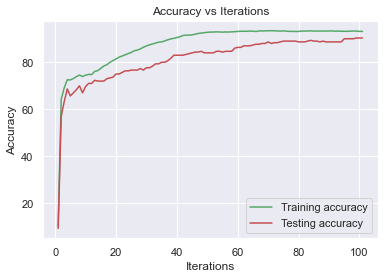

In [101]:
plot_acc(train_acc_list,test_acc_list,'1')

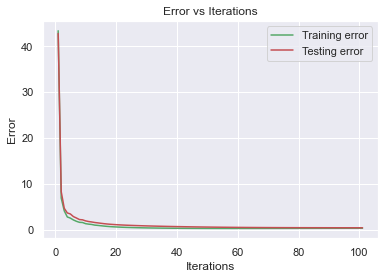

In [102]:
plot_error(train_error_list,test_error_list,'1')

In [103]:
train_acc_list[-1],test_acc_list[-1]

(0.9314814814814815, 0.9033333333333333)

(<matplotlib.image.AxesImage at 0x26b019e8c08>, 5)

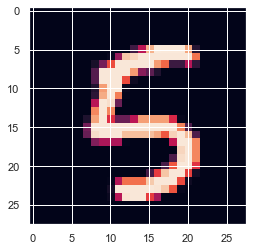

In [258]:
idx = 1
plt.imshow(np.array(Xorig[idx]).reshape(28,28)),Yorig[idx]

In [259]:
nn.f_prop(Xorig[1][:])

In [108]:
np.array(Xorig[1][:]).shape

(784,)

In [144]:
preds = nn.predict(Xorig[:300])
y_pred = []
for p in preds:
    y_pred.append(np.argmax(p))

In [145]:
idx = []
orig = Yorig[:300]
for i in range(len(orig)):
    if y_pred[i] != orig[i]:
        idx.append(i)
        if len(idx)==3:
            break

In [126]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [136]:
confusion_matrix(y_pred[:300],Yorig[:300])

array([[26,  0,  0,  2,  0,  1,  1,  0,  0,  0],
       [ 0, 24,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  1, 26,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 18,  0,  1,  0,  0,  2],
       [ 0,  0,  0,  0,  0, 26,  2,  0,  1,  0],
       [ 0,  0,  1,  0,  0,  0, 24,  0,  1,  0],
       [ 0,  1,  1,  0,  0,  0,  0, 32,  0,  1],
       [ 0,  1,  0,  0,  0,  2,  0,  0, 32,  0],
       [ 0,  0,  0,  0,  3,  0,  0,  1,  0, 27]], dtype=int64)

In [139]:
df_confusion = pd.crosstab([Yorig[:300]], [y_pred[:300]], rownames=['Actual'], colnames=['Predicted'], margins=True)

In [140]:
df_confusion

Predicted,0,1,2,3,4,5,6,7,8,9,All
Actual,,,,,,,,,,,
0,26,0,0,0,0,0,0,0,0,0,26
1,0,24,1,0,0,0,0,1,1,0,27
2,0,0,26,0,0,0,1,1,0,0,28
3,2,0,1,38,0,0,0,0,0,0,41
4,0,0,0,0,18,0,0,0,0,3,21
5,1,0,0,1,0,26,0,0,2,0,30
6,1,0,0,0,1,2,24,0,0,0,28
7,0,0,0,0,0,0,0,32,0,1,33
8,0,1,0,1,0,1,1,0,32,0,36


(<matplotlib.image.AxesImage at 0x27dcc3e4e88>, 6, 4)

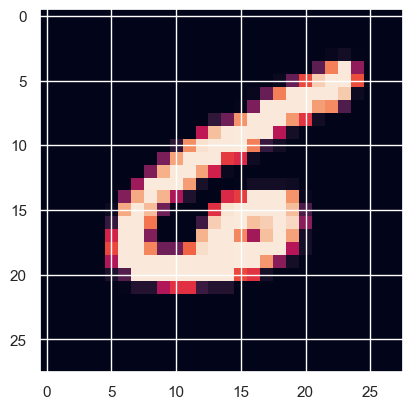

In [169]:
plt.imshow(np.array(Xorig[idx[0]]).reshape(28,28)),orig[idx[0]], y_pred[idx[0]]

(<matplotlib.image.AxesImage at 0x27dcbfb7408>, 5, 0)

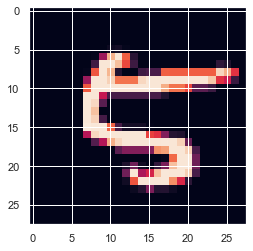

In [156]:
plt.imshow(np.array(Xorig[idx[1]]).reshape(28,28)),orig[idx[1]], y_pred[idx[1]]

(<matplotlib.image.AxesImage at 0x27dcc056488>, 4, 9)

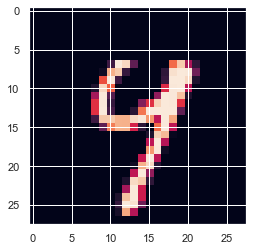

In [157]:
plt.imshow(np.array(Xorig[idx[2]]).reshape(28,28)),orig[idx[2]], y_pred[idx[2]]

(<matplotlib.image.AxesImage at 0x27dcc179b08>, 9)

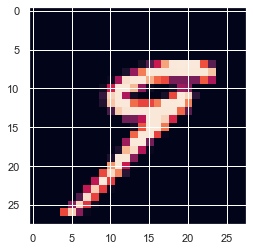

In [162]:
plt.imshow(np.array(Xorig[0]).reshape(28,28)),Yorig[0]

In [159]:
nn.f_prop(Xorig[0])

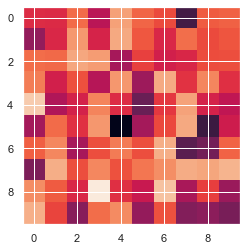

In [160]:
plt.imshow(np.array(nn.z[0]).reshape(10,10))

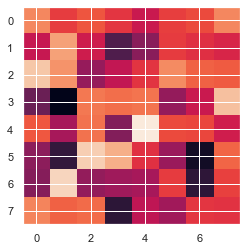

In [161]:
plt.imshow(np.array(nn.z[1]).reshape(8,8))